# Insight

Get some interpretations over experiment results

In [1]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["MKL_NUM_THREADS"] = '6'
os.environ["NUMEXPR_NUM_THREADS"] = '6'
os.environ["OMP_NUM_THREADS"] = '6'

## Load VIGOR dataset & visualize batches

In [2]:
import yaml
from easydict import EasyDict as edict  
from loguru import logger
from clsslcvm.tools import get_dataset
from clsslcvm.tools.visualize import visualize_assets, visualize_featdist, visualize_featdistv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,30)
import os
import glob
import numpy as np
import torch

In [7]:
cfg_file = 'configs/train_cvm_debug.yaml'
with open(cfg_file, 'r') as f:
    cfg = edict(yaml.load(f, Loader=yaml.Loader))

In [8]:
train_set, train_loader, val_set, val_set_queries_grd, val_set_queries_sat, \
                val_loader_queries_grd, val_loader_queries_sat = get_dataset(cfg, logger)

2022-06-28 20:44:18.554 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:77 - VIGOR dataset: load data/VIGOR/splits_newfull/NewYork/satellite_list.txt: 23279
2022-06-28 20:44:18.695 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:77 - VIGOR dataset: load data/VIGOR/splits_newfull/Seattle/satellite_list.txt: 44055
2022-06-28 20:44:18.710 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:80 - train sat loaded, data size:44055
2022-06-28 20:44:19.586 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:107 - VIGOR dataset: load data/VIGOR/splits_newfull/NewYork/pano_label_balanced.txt: 27769
2022-06-28 20:44:20.402 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:107 - VIGOR dataset: load data/VIGOR/splits_newfull/Seattle/pano_label_balanced.txt: 51520
2022-06-28 20:44:20.463 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:111 - train grd loaded, data_size: 51520
2022-06-28 20:44:20.585 | INFO     | clsslcvm.datasets.vigor_dataset:read_info:77 - VIGOR data

In [9]:
import ipywidgets as widgets
from IPython.display import display, clear_output

button = widgets.Button(
	description='Next Batch',
	layout=widgets.Layout(width='10%')
)
out = widgets.Output()
# it = iter(train_loader)
it = iter(train_loader)

def on_button_clicked(_):
	#https://medium.com/@jdchipox/how-to-interact-with-jupyter-33a98686f24e
	with out:
		try:
			batch_sat, batch_grd, indice, delta = next(it)
		except StopIteration:
			print("Data loader ran out.")
		clear_output()
		# display(f'')
		sample_slider = widgets.IntSlider(
			value=0, min=0, max=cfg.train.batch_size-1, step=2, 
			description='Sample:',
			layout=widgets.Layout(width='25%')
		)
		widgets.interact(lambda i: visualize_assets(batch_grd[i:i+2], batch_sat[i:i+2]),
						i=sample_slider)
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])

## Visualize featdist - pca

In [3]:
# exp_path = 'work_dirs/Jun13-1620_cvm_vgg16_fc_vigor_newfull'
# exp_path = 'work_dirs/Jun14-0425_cvm_vgg16_fc_vigor_newfull'
# exp_path = 'work_dirs/Jun14-0407_cvm_vgg16_fc_vigor_newfull'
# exp_path = 'work_dirs/Jun13-1623_cvm_vgg16_fc_vigor_newfull'

# exp_path = 'work_dirs/Jun14-1642_cvm_vgg16_fc_vigor_newfull'
# exp_path = 'work_dirs/Jun14-1649_cvm_vgg16_fc_vigor_newfull'

# exp_path = 'work_dirs/Jun27-1644_cvm_vgg16_fc_vigor_newfull'
# exp_path = 'work_dirs/Jun27-1647_cvm_vgg16_fc_vigor_newfull'
exp_path = 'work_dirs/Jun27-2314_cvm_vgg16_fc_vigor_newfull'
### exp_path = 'work_dirs/Jun27-2328_cvm_vgg16_fc_vigor_newfull'
### exp_path = 'work_dirs/Jun27-2338_cvm_vgg16_fc_vigor_newfull'

start_epoch = 0
total_epochs = 99
step = 3

analysis_path = os.path.join(exp_path, 'analysis')
if not os.path.isdir(analysis_path):
    os.makedirs(analysis_path)

### Visualize featdist - pca

In [17]:
from sklearn.decomposition import PCA
desc_grd_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_grd_all_epoch{start_epoch}.npy'))
desc_sat_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_sat_all_epoch{start_epoch}.npy'))
feat = np.concatenate([desc_grd_all, desc_sat_all], axis=0)
pca = PCA(n_components=2)
X_embedded = pca.fit(feat)

In [ ]:
for epoch in range(start_epoch, total_epochs + 1, step):
    desc_grd_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_grd_all_epoch{epoch}.npy'))
    desc_sat_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_sat_all_epoch{epoch}.npy'))
    desc_grd_all = desc_grd_all[:2000]
    desc_sat_all = desc_sat_all[val_set.grd_sat_label[:2000][:, 0]]
    save_path = os.path.join(analysis_path, f'featdist_epoch{epoch}')
    visualize_featdist(desc_grd_all, desc_sat_all, save_path, 'pca', save_path, pca)

In [ ]:
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display, clear_output
plots = glob.glob(f'{analysis_path}/featdist*.png')
plots = sorted(plots, key=lambda x:int(x.split('/')[-1][14:-4]))
print(len(plots))
sample_slider = widgets.IntSlider(
    value=0, min=0, max=len(plots)-1, step=1, 
    description='Plot:',
    layout=widgets.Layout(width='25%')
)
def helper(i):
    plt.imshow(mpimg.imread(plots[i]), aspect=0.75)
    plt.axis('off')
    plt.show()
widgets.interact(lambda i : helper(i), i=sample_slider)

21


interactive(children=(IntSlider(value=0, description='Plot:', layout=Layout(width='25%'), max=20), Output()), …

<function __main__.<lambda>(i)>

### Visualize featdist - manually tsne

In [10]:
# desc_grd_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_grd_all_epoch{0}.npy'))
# desc_sat_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_sat_all_epoch{0}.npy'))
desc_grd_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_grd_all_epoch{total_epochs}.npy'))
desc_sat_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_sat_all_epoch{total_epochs}.npy'))

print(desc_grd_all.shape[0], desc_sat_all.shape[0])

53694 46563


In [11]:
# desc_grd = np.concatenate([desc_grd_all[:1000], desc_grd_all[-1000:]], axis=0)
# desc_sat = np.concatenate([desc_sat_all[val_set.grd_sat_label[:1000][:, 0]], 
#                            desc_sat_all[val_set.grd_sat_label[-1000:][:, 0]]], axis=0)

In [12]:
# sat: -> 24255, grd: -> 28215
desc_grd = np.concatenate([desc_grd_all[:20000][::4], desc_grd_all[-20000:][::4]], axis=0)
desc_sat = np.concatenate([desc_sat_all[val_set.grd_sat_label[:20000][::4][:, 0]], 
                           desc_sat_all[val_set.grd_sat_label[-20000:][::4][:, 0]]], axis=0)
n_gr, n_sa = desc_grd.shape[0], desc_sat.shape[0]
print(n_gr, n_sa)

10000 10000


In [ ]:
# visualize_featdistv2(desc_grd_all, desc_sat_all, '', 'tsne')

#### fit separately

In [13]:
from sklearn.manifold import TSNE
X_embedded_gr = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(desc_grd)
X_embedded_sa = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(desc_sat)
X_embedded = np.concatenate([X_embedded_gr, X_embedded_sa], axis=0)

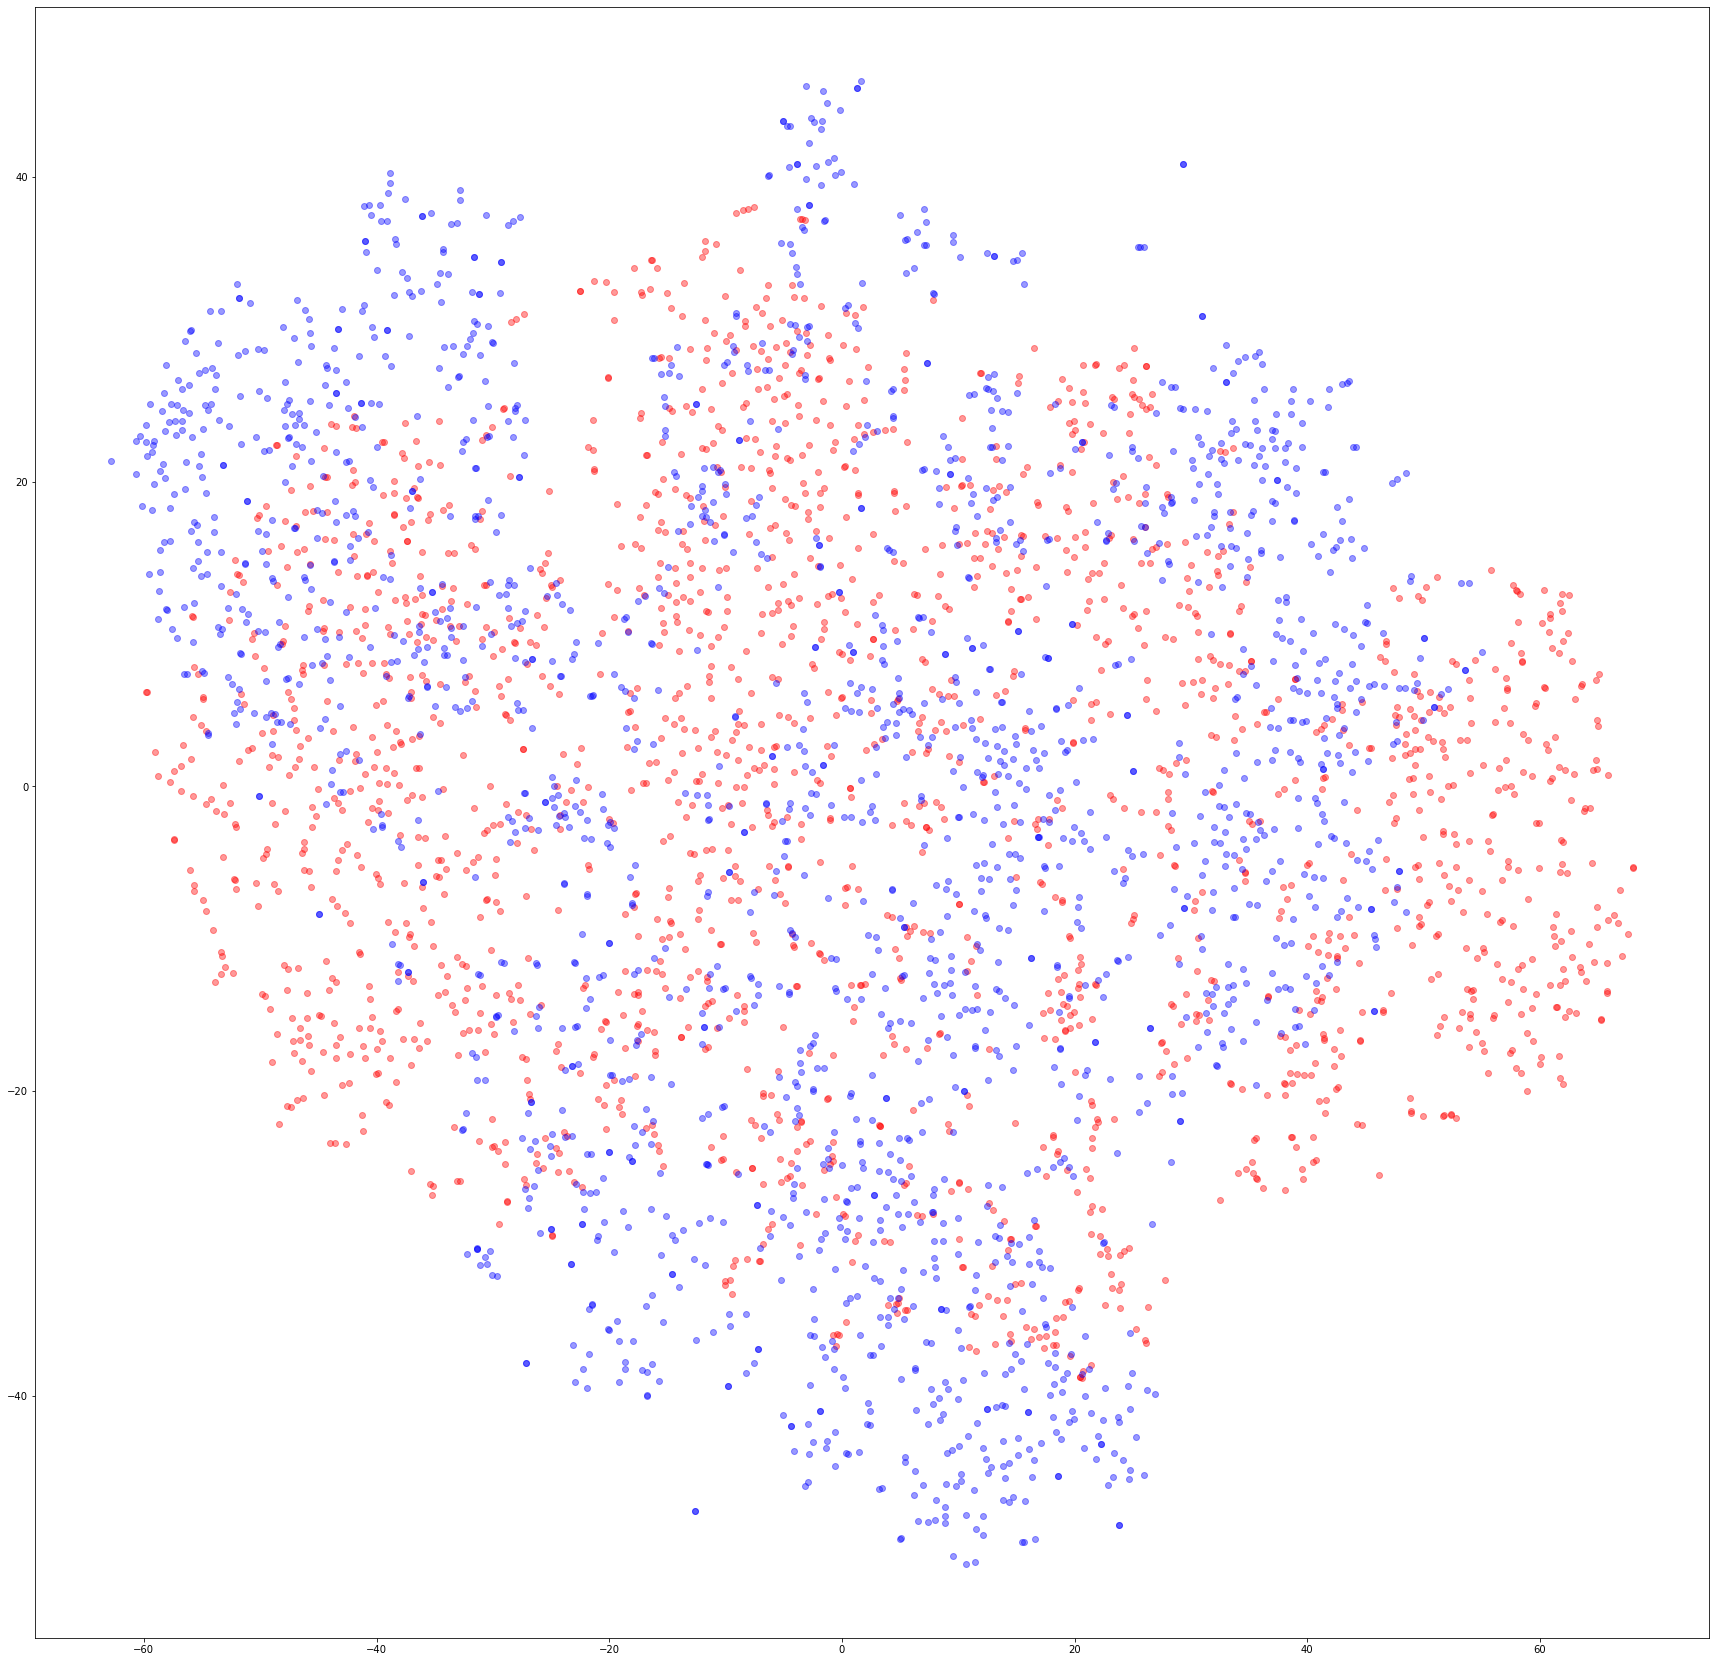

In [14]:
n_gr, n_sa = desc_grd.shape[0], desc_sat.shape[0]

plt.scatter(X_embedded[:n_gr, 0], X_embedded[:n_gr, 1], c='r', alpha=0.4)
plt.scatter(X_embedded[n_gr:, 0], X_embedded[n_gr:, 1], c='b', alpha=0.4)
plt.show()

#### fit together

In [13]:
from sklearn.manifold import TSNE
qFeat = np.concatenate([desc_grd, desc_sat], axis=0)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(qFeat)

In [14]:
print(n_gr, n_sa)
print(X_embedded.shape)

10000 10000
(20000, 2)


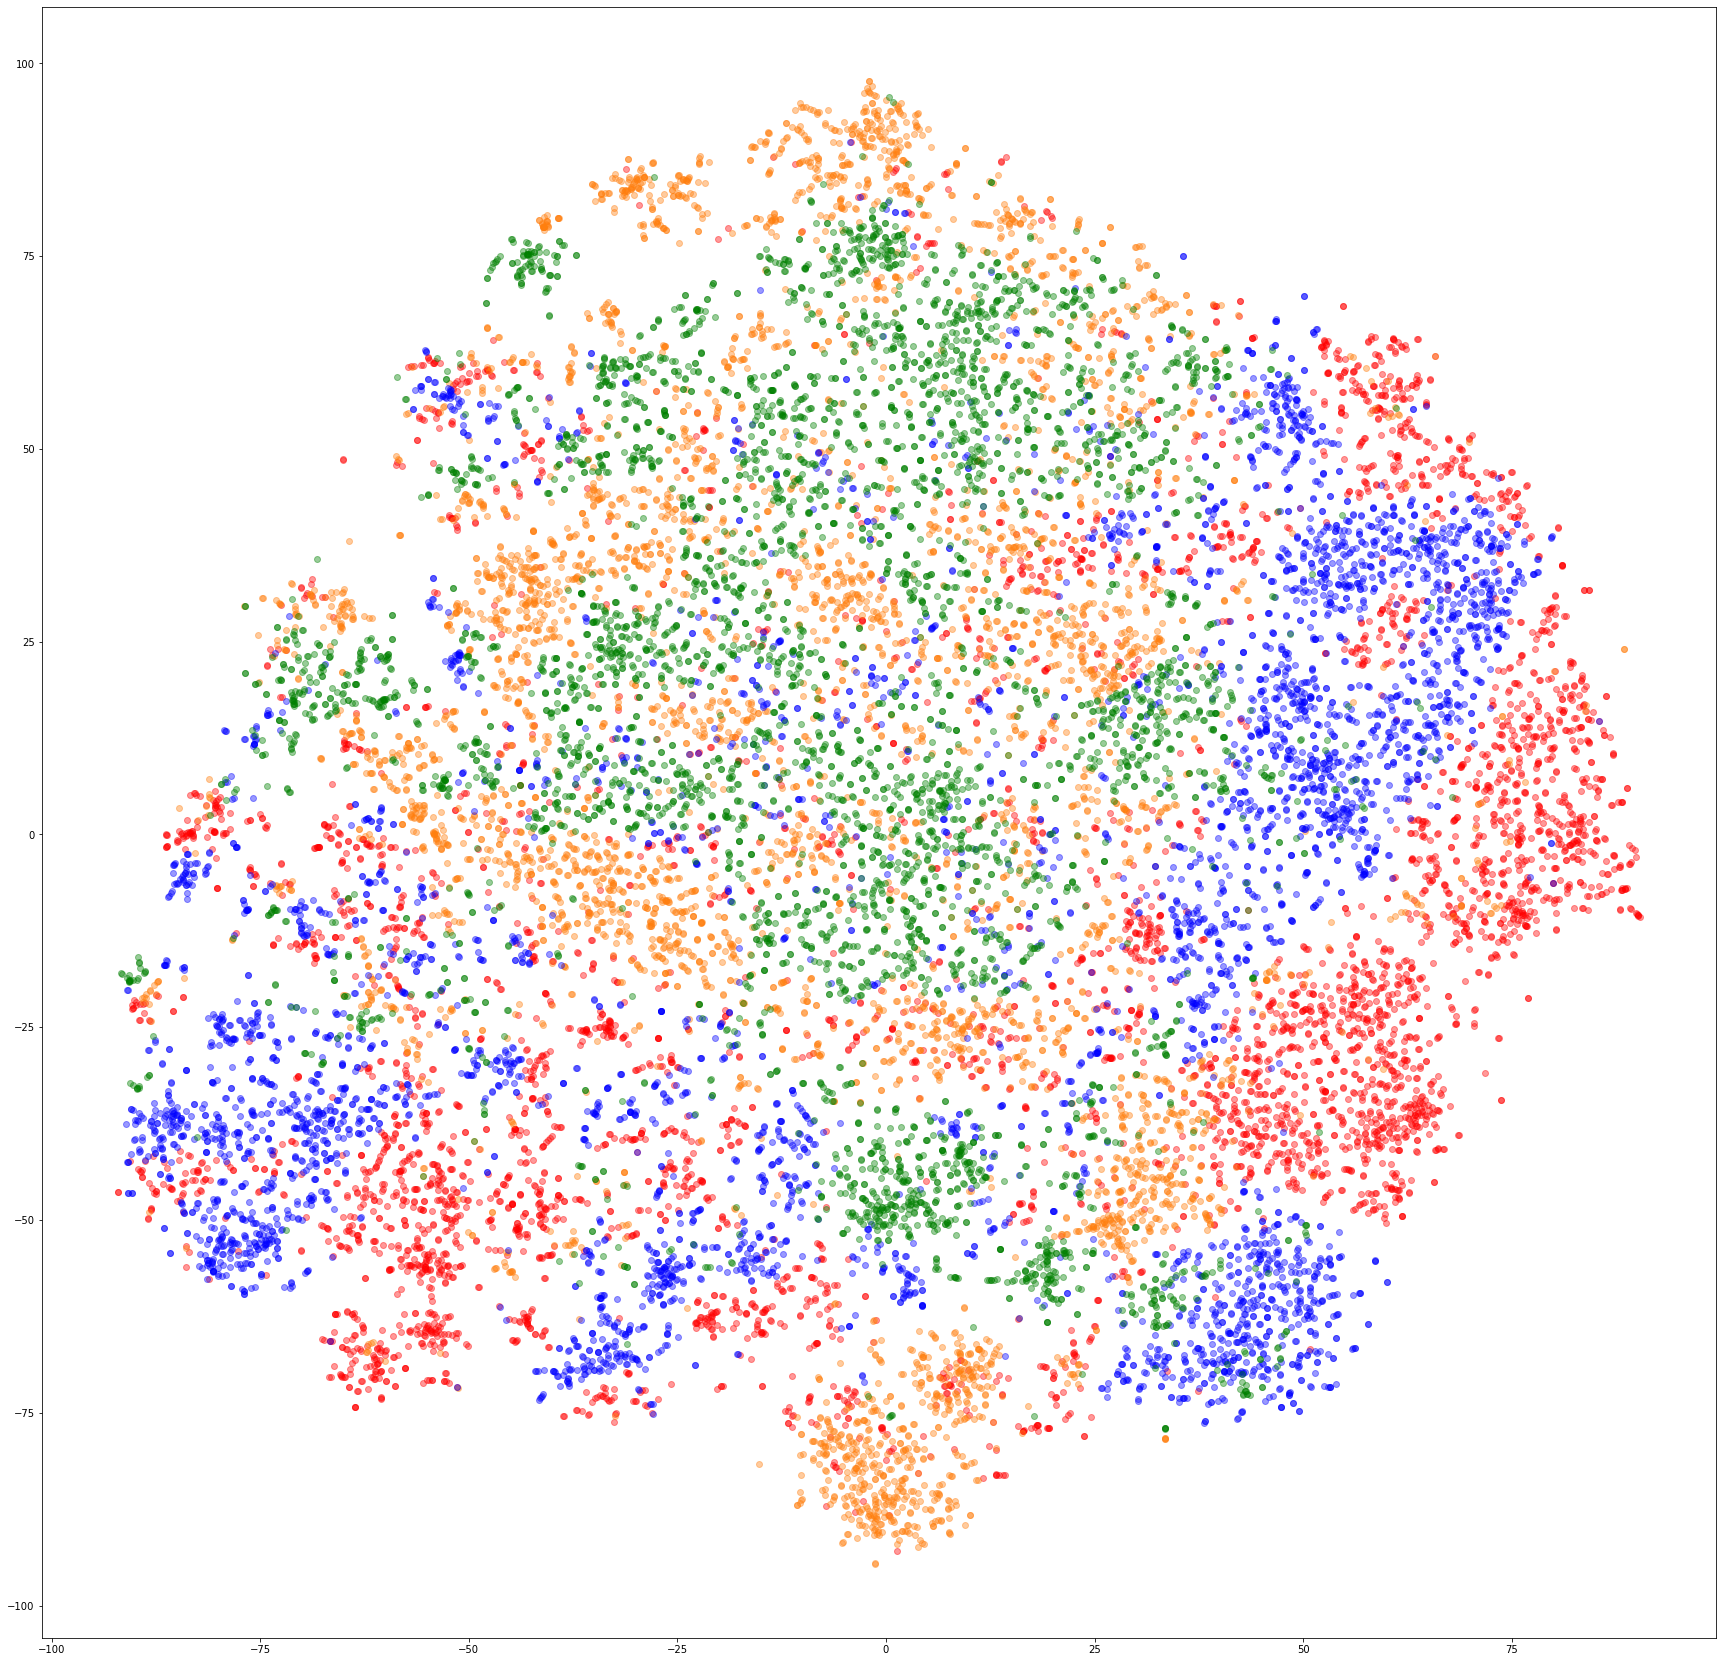

In [15]:
plt.scatter(X_embedded[:n_gr//2, 0], X_embedded[:n_gr//2, 1], c='r', alpha=0.4)
plt.scatter(X_embedded[n_gr//2:n_gr, 0], X_embedded[n_gr//2:n_gr, 1], c='C1', alpha=0.4)
plt.scatter(X_embedded[n_gr:n_gr + n_sa//2, 0], X_embedded[n_gr:n_gr + n_sa//2, 1], c='b', alpha=0.4)
plt.scatter(X_embedded[n_gr + n_sa//2:, 0], X_embedded[n_gr + n_sa//2:, 1], c='g', alpha=0.4)
plt.show()

## Visualize descriptors

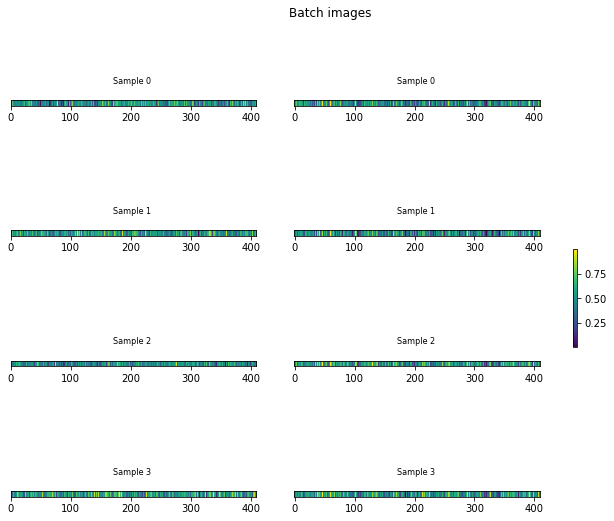

In [14]:
from clsslcvm.tools.visualize import visualize_assets

desc_grd_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_grd_all_epoch{total_epochs}.npy'))
desc_sat_all = np.load(os.path.join(exp_path, 'checkpoints', f'desc_sat_all_epoch{total_epochs}.npy'))
desc_grd_all = desc_grd_all[:4]
desc_sat_all = desc_sat_all[:4]
visualize_assets(torch.tensor(desc_grd_all), torch.tensor(desc_sat_all), mode='descriptor')

## Check feature map

## Summary writer

In [1]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()
